In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math

from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [2]:
from matplotlib import rcParams
rcParams["figure.figsize"] = (12, 6)
rcParams["lines.linewidth"] = 3
rcParams["xtick.labelsize"] = "x-large"
rcParams["ytick.labelsize"] = "x-large"

In [3]:
data1 = pd.read_csv("train.csv")
data1.shape

(891, 12)

In [4]:
data1.sample(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
437,438,1,2,"Richards, Mrs. Sidney (Emily Hocking)",female,24.0,2,3,29106,18.7500,NaN,S
396,397,0,3,"Olsson, Miss. Elina",female,31.0,0,0,350407,7.8542,NaN,S
154,155,0,3,"Olsen, Mr. Ole Martin",male,NaN,0,0,Fa 265302,7.3125,NaN,S
595,596,0,3,"Van Impe, Mr. Jean Baptiste",male,36.0,1,1,345773,24.1500,NaN,S
616,617,0,3,"Danbom, Mr. Ernst Gilbert",male,34.0,1,1,347080,14.4000,NaN,S


In [5]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
data1.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
data1.dropna(subset=["Embarked"], inplace=True)

In [8]:
data1["Age"] = data1["Age"].fillna(data1["Age"].median())

In [9]:
data1["Title"] = data1["Name"].str.extract(r' ([A-Za-z]+)\.', expand=False)
rare_titles = ["Lady", "Countess", "Capt", "Col", "Don", "Dr", "Major", "Rev", "Sir", "Jonkheer", "Dona"]

data1["Title"] = data1["Title"].replace(rare_titles, "Rare")
data1["Title"] = data1["Title"].replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})
data1["FamilySize"] = data1["SibSp"] + data1["Parch"] + 1
data1["IsAlone"] = (data1["FamilySize"] == 1).astype(int)

In [10]:
data2 = data1.drop(columns=["Cabin", "Ticket"])

In [11]:
data2.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Title          0
FamilySize     0
IsAlone        0
dtype: int64

In [12]:
print(data2.duplicated().sum())

0


In [13]:
data2 = data2.drop(columns=["PassengerId", "Name"])

In [14]:
target = "Survived"
id_col = "PassengerId"

num = ["Pclass", "Age", "SibSp", "Parch", "Fare", "FamilySize", "IsAlone"]
cat = ["Sex", "Embarked", "Title"]

In [15]:
data2[cat].describe()

,Sex,Embarked,Title
count,889,889,889
unique,2,3,5
top,male,S,Mr
freq,577,644,517


In [16]:
data2[num].describe()

,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone
count,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000,889.000000
mean,2.311586,29.315152,0.524184,0.382452,32.096681,1.906637,0.601800
std,0.834700,12.984932,1.103705,0.806761,49.697504,1.614703,0.489803
min,1.000000,0.420000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,22.000000,0.000000,0.000000,7.895800,1.000000,0.000000
50%,3.000000,28.000000,0.000000,0.000000,14.454200,1.000000,1.000000
75%,3.000000,35.000000,1.000000,0.000000,31.000000,2.000000,1.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,11.000000,1.000000


In [17]:
for col in cat:
    print(f"value count column {col} :")
    print(data2[col].value_counts())
    print()

value count column Sex :
Sex
male      577
female    312
Name: count, dtype: int64

value count column Embarked :
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

value count column Title :
Title
Mr        517
Miss      184
Mrs       125
Master     40
Rare       23
Name: count, dtype: int64



## UNIVARIATE ANALYSIS

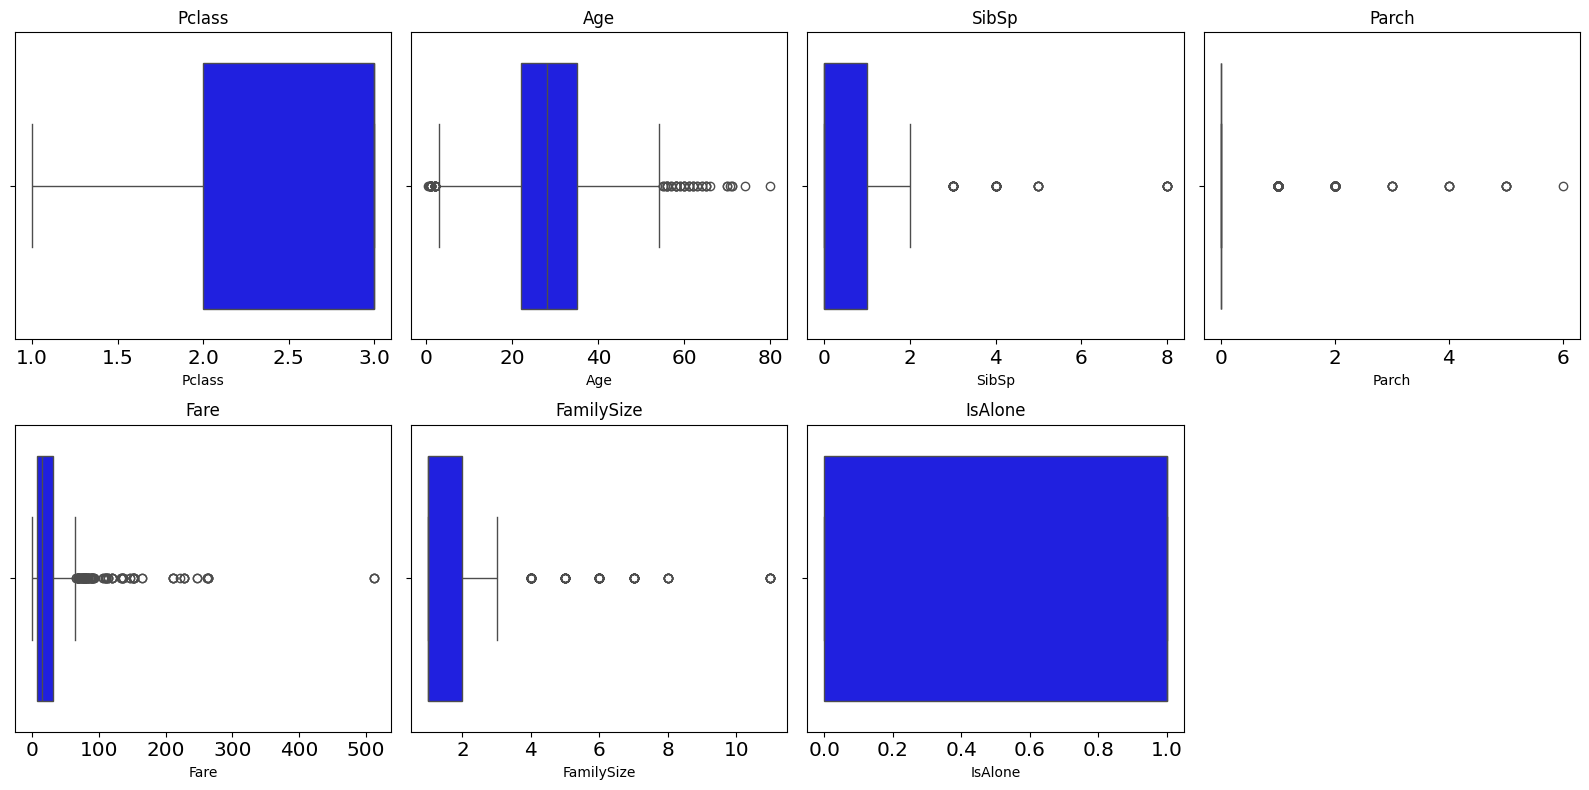

In [18]:
plt.figure(figsize=(16, 8))

for i, col in enumerate(num):
    plt.subplot(2, 4, i + 1)
    sns.boxplot(x=data2[col], color="blue")
    plt.title(col)

plt.tight_layout()
plt.show()

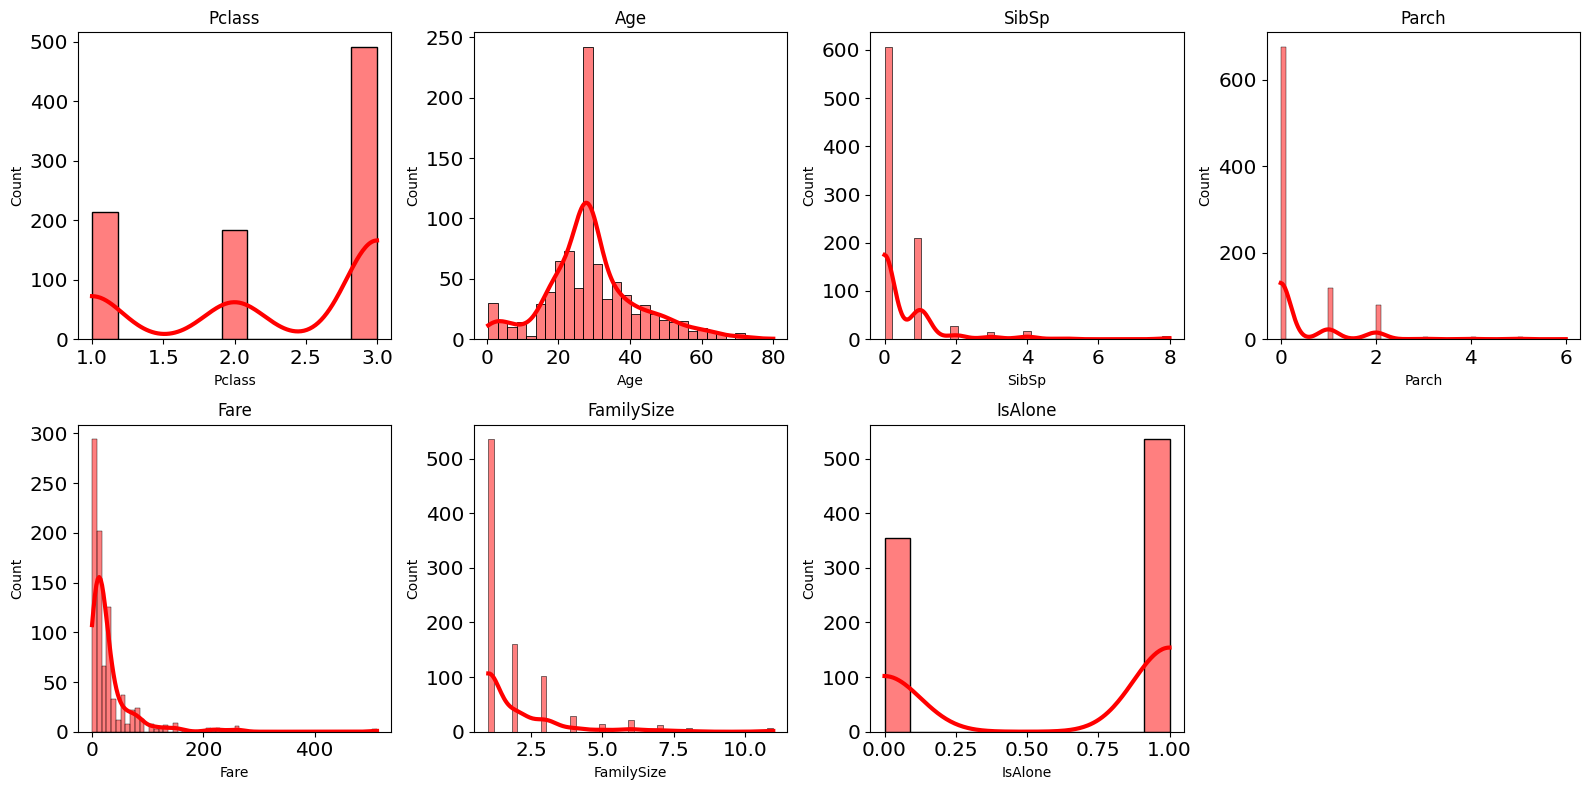

In [19]:
plt.figure(figsize=(16, 8))

for i, col in enumerate(num):
    plt.subplot(2, 4, i + 1)
    sns.histplot(data=data2, x=col, kde=True, color="red")
    plt.title(col)

plt.tight_layout()
plt.show()

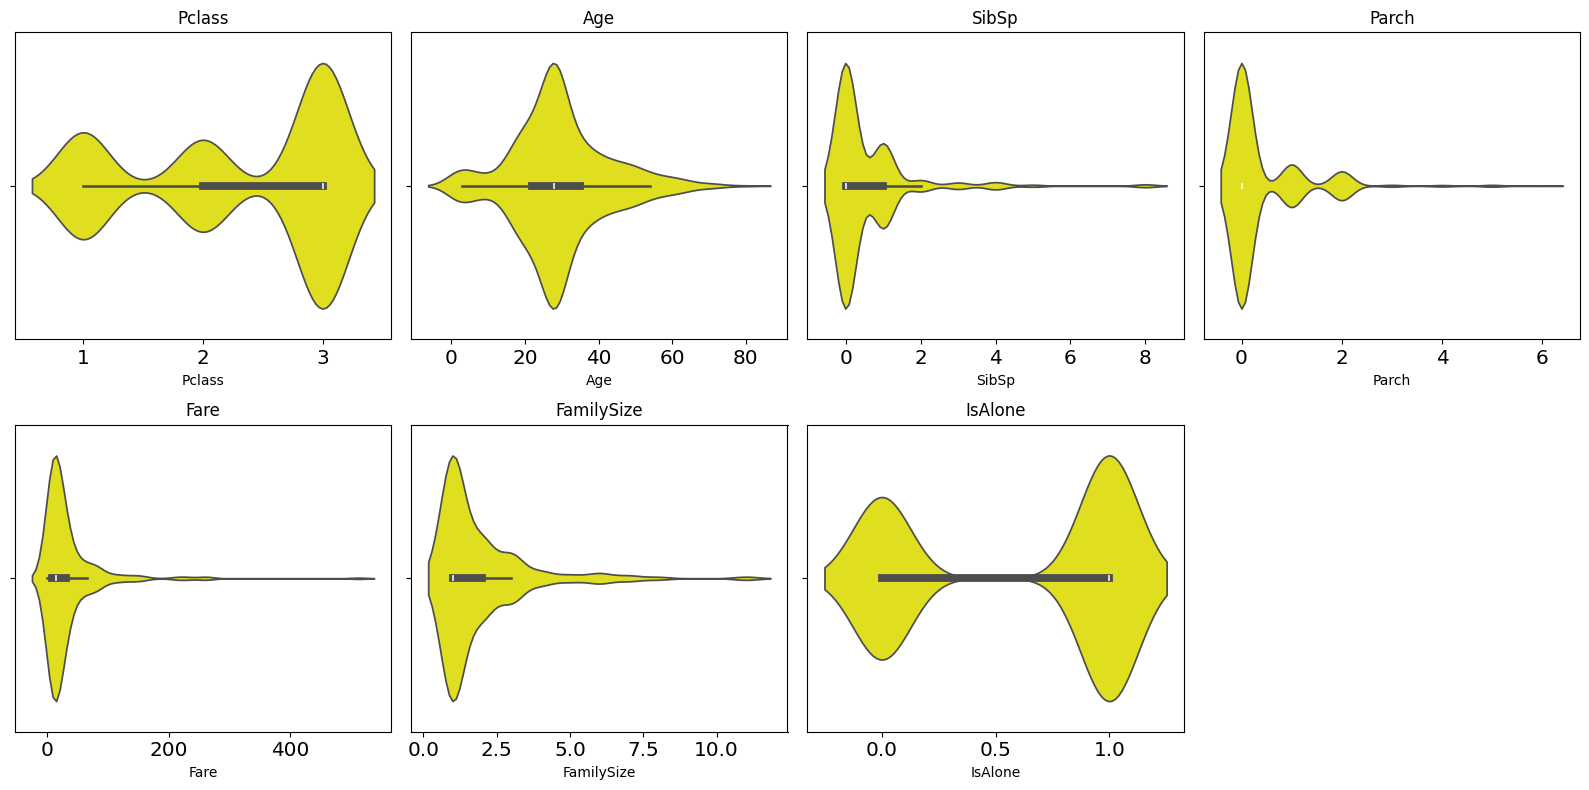

In [20]:
plt.figure(figsize=(16, 8))

for i, col in enumerate(num):
    plt.subplot(2, 4, i + 1)
    sns.violinplot(x=data2[col], color="yellow")
    plt.title(col)

plt.tight_layout()
plt.show()

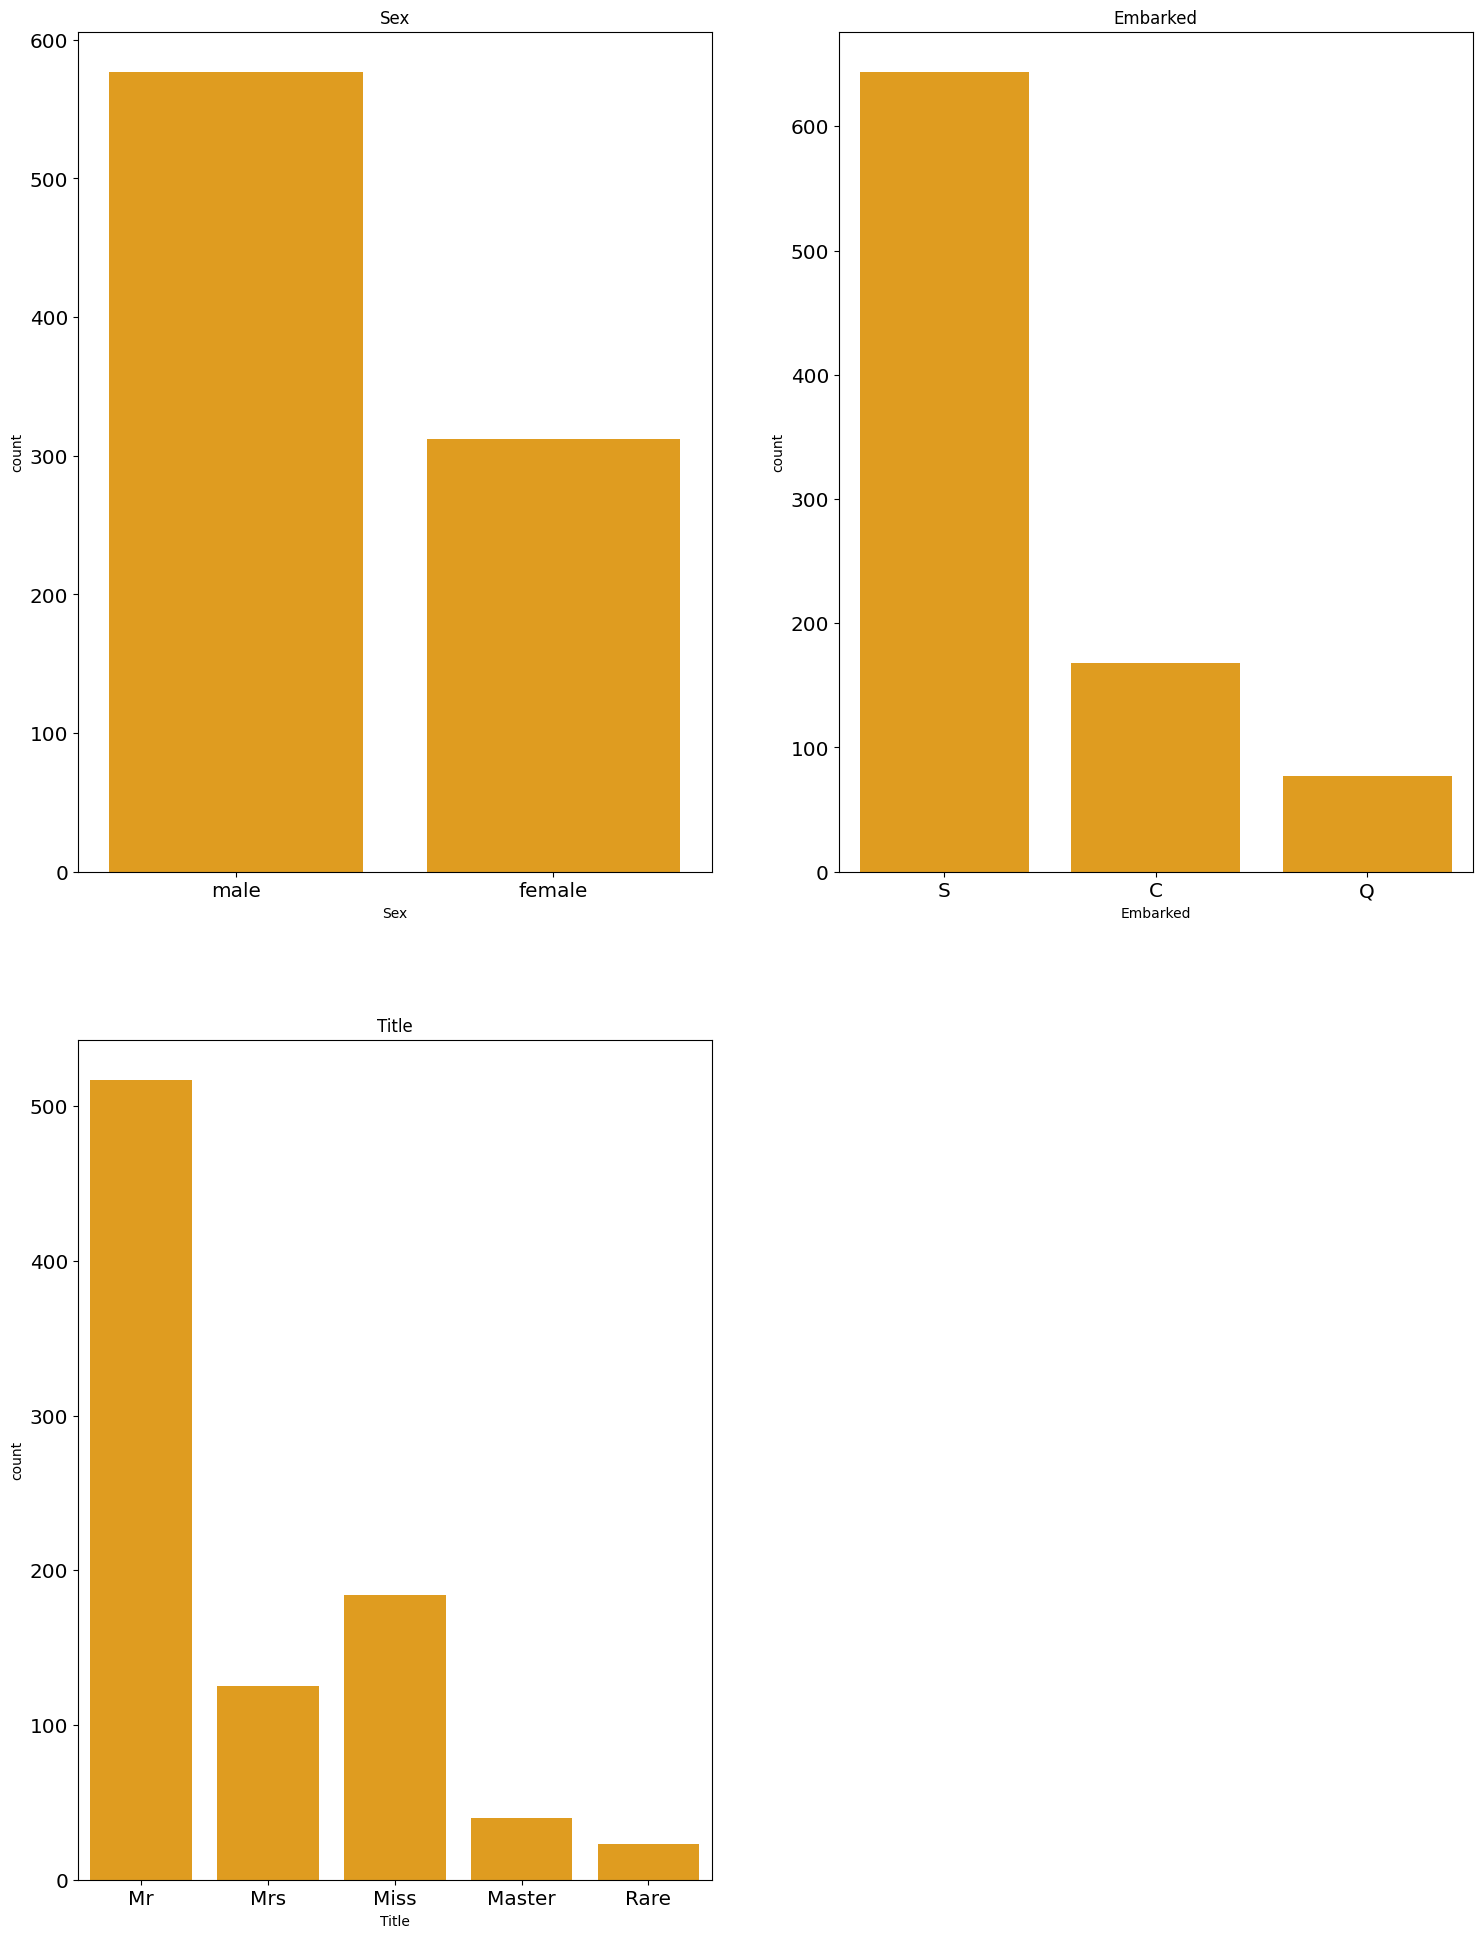

In [21]:
plt.figure(figsize=(18, 24))

for i, col in enumerate(cat):
    plt.subplot(2, 2, i + 1)
    
    sns.countplot(
        data=data2,
        x=col,
        color="orange"
    )
    
    plt.title(col)
    # plt.xticks(rotation=45)

# plt.tight_layout()
plt.show()

In [22]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    889 non-null    int64  
 1   Pclass      889 non-null    int64  
 2   Sex         889 non-null    object 
 3   Age         889 non-null    float64
 4   SibSp       889 non-null    int64  
 5   Parch       889 non-null    int64  
 6   Fare        889 non-null    float64
 7   Embarked    889 non-null    object 
 8   Title       889 non-null    object 
 9   FamilySize  889 non-null    int64  
 10  IsAlone     889 non-null    int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 83.3+ KB


In [23]:
data2.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FamilySize,IsAlone
0,0,3,male,22.0,1,0,7.2500,S,Mr,2,0
1,1,1,female,38.0,1,0,71.2833,C,Mrs,2,0
2,1,3,female,26.0,0,0,7.9250,S,Miss,1,1
3,1,1,female,35.0,1,0,53.1000,S,Mrs,2,0
4,0,3,male,35.0,0,0,8.0500,S,Mr,1,1


## Bivariate Analysis

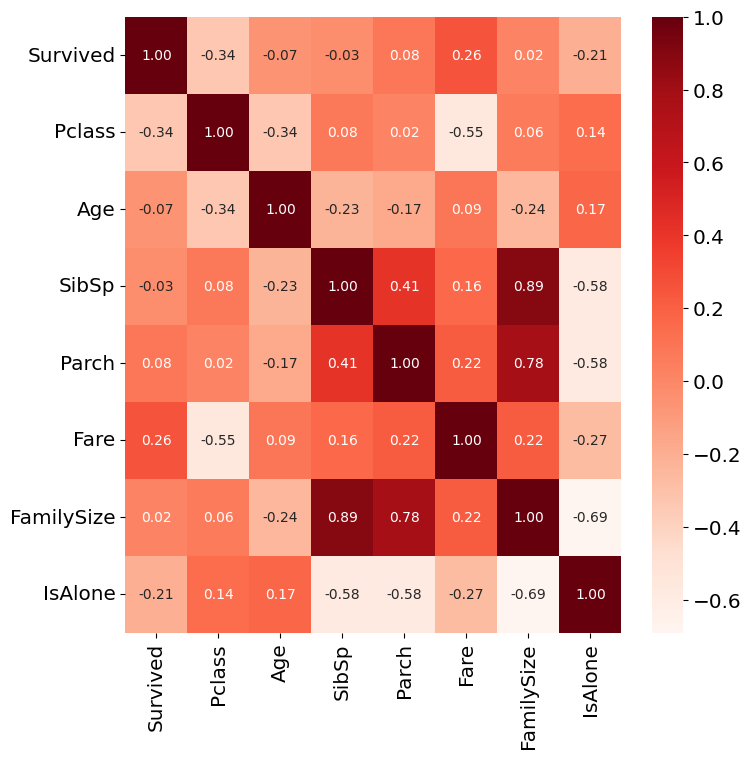

In [24]:
plt.figure(figsize=(8, 8))
corr_matrix = data2.select_dtypes(include="number").corr()

sns.heatmap(
    corr_matrix,
    cmap="Reds",
    annot=True,
    fmt=".2f"
)

plt.show()

<Figure size 1000x1000 with 0 Axes>

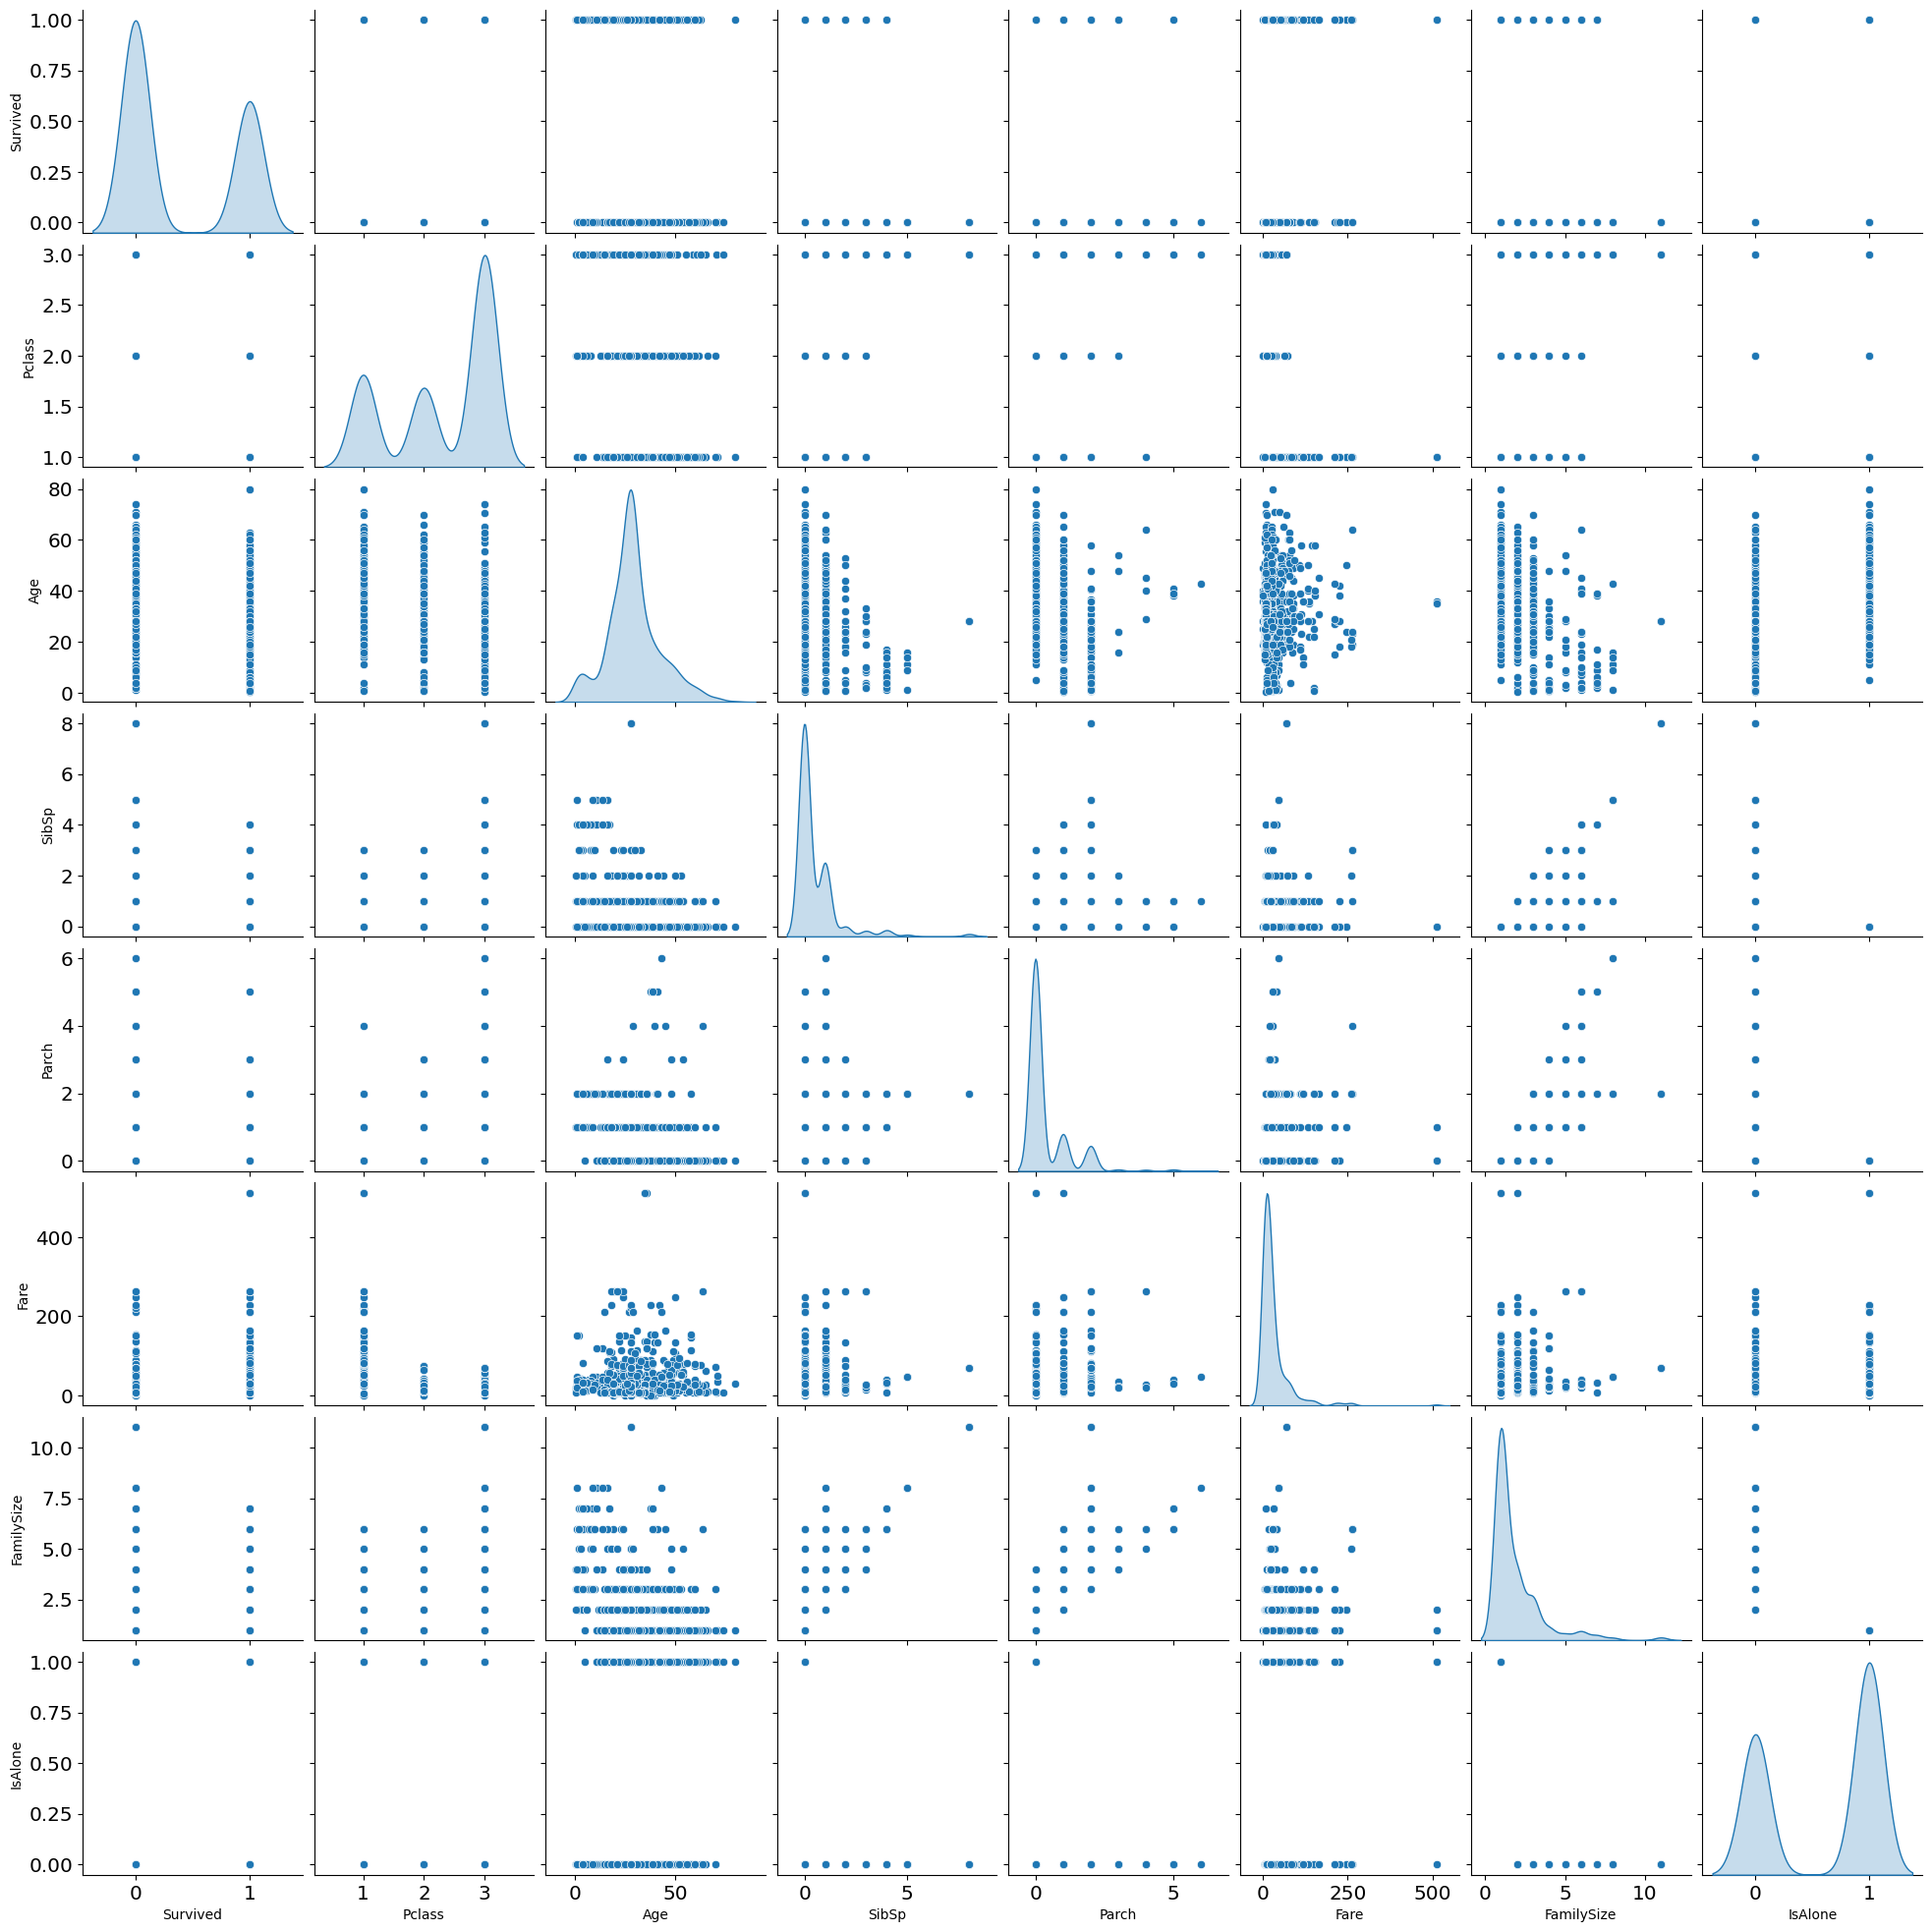

In [25]:
plt.figure(figsize=(10, 10))
sns.pairplot(
    data2,
    diag_kind="kde"
)
plt.show()

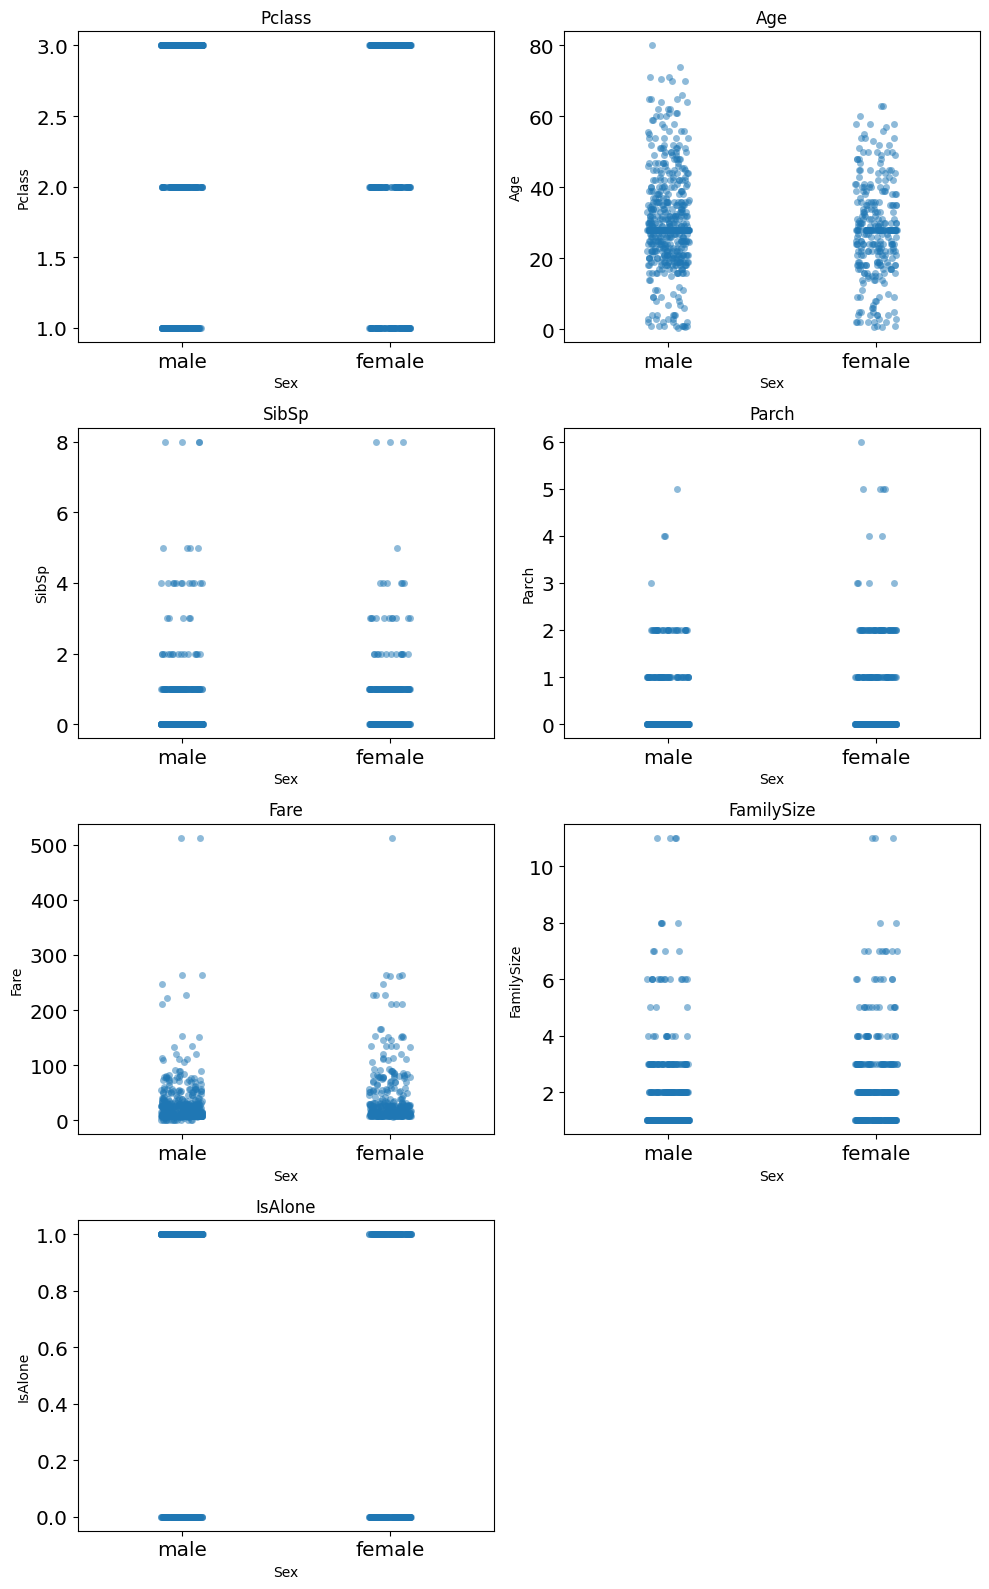

In [26]:
n_cols = 2
n_rows = math.ceil(len(num) / n_cols)

plt.figure(figsize=(10, 4 * n_rows))

for i, col in enumerate(num):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.stripplot(
        data=data2,
        x="Sex",
        y=col,
        jitter=True,
        alpha=0.5
    )
    plt.title(col)

plt.tight_layout()
plt.show()

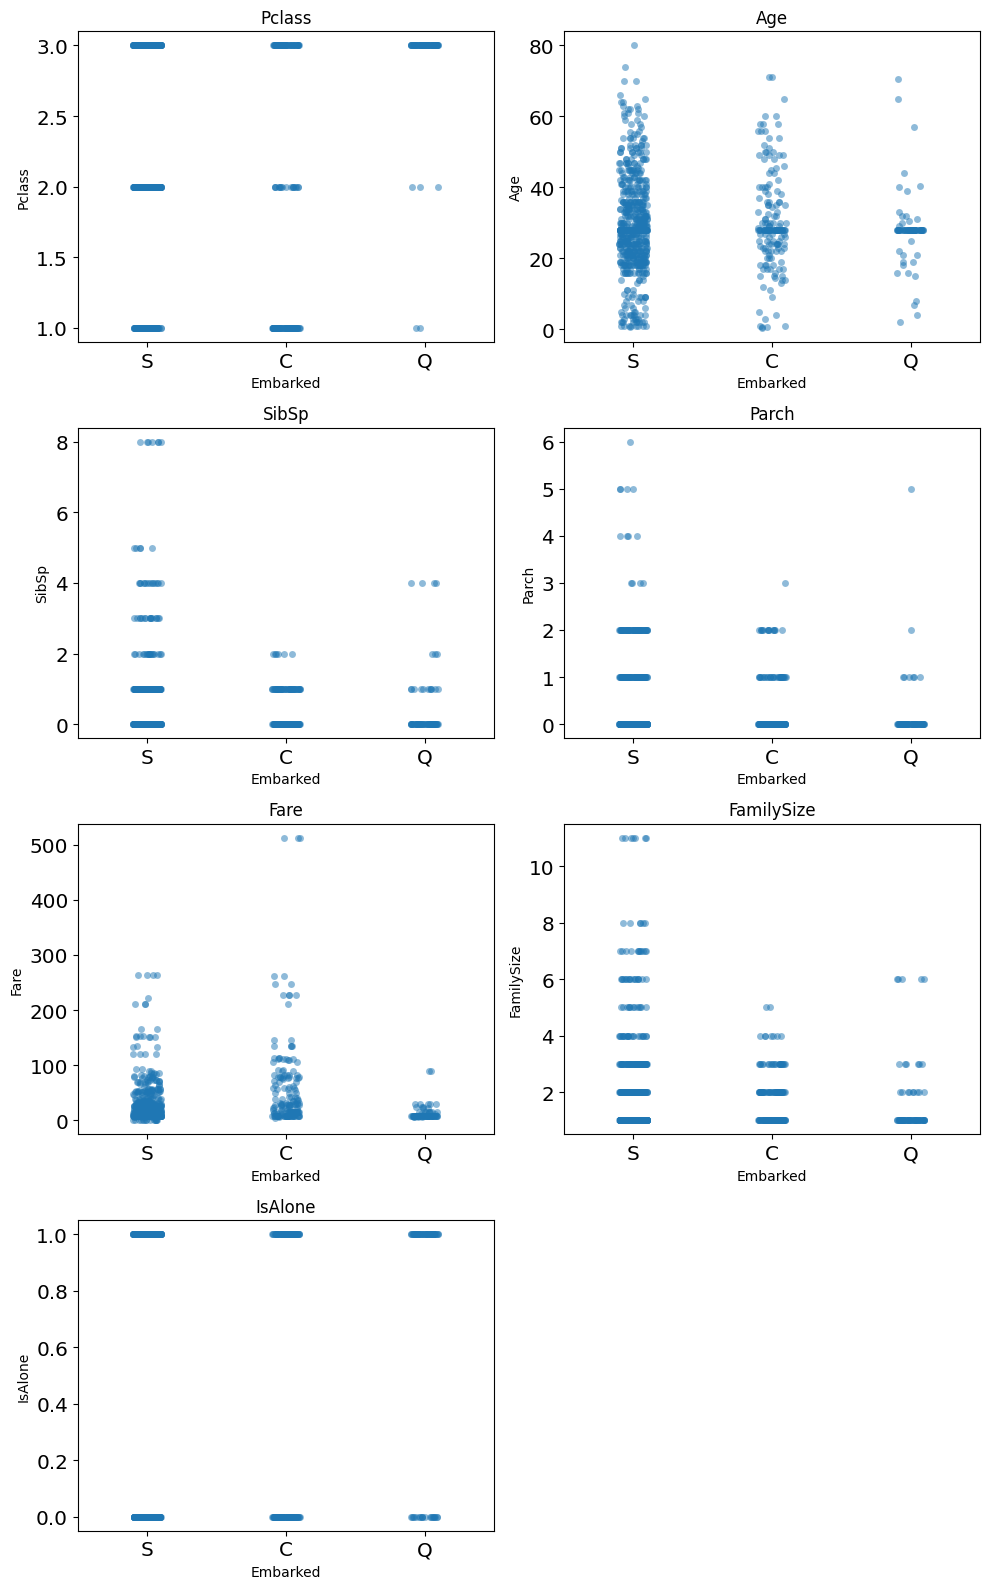

In [27]:
n_cols = 2
n_rows = math.ceil(len(num) / n_cols)

plt.figure(figsize=(10, 4 * n_rows))

for i, col in enumerate(num):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.stripplot(
        data=data2,
        x="Embarked",
        y=col,
        jitter=True,
        alpha=0.5
    )
    plt.title(col)

plt.tight_layout()
plt.show()

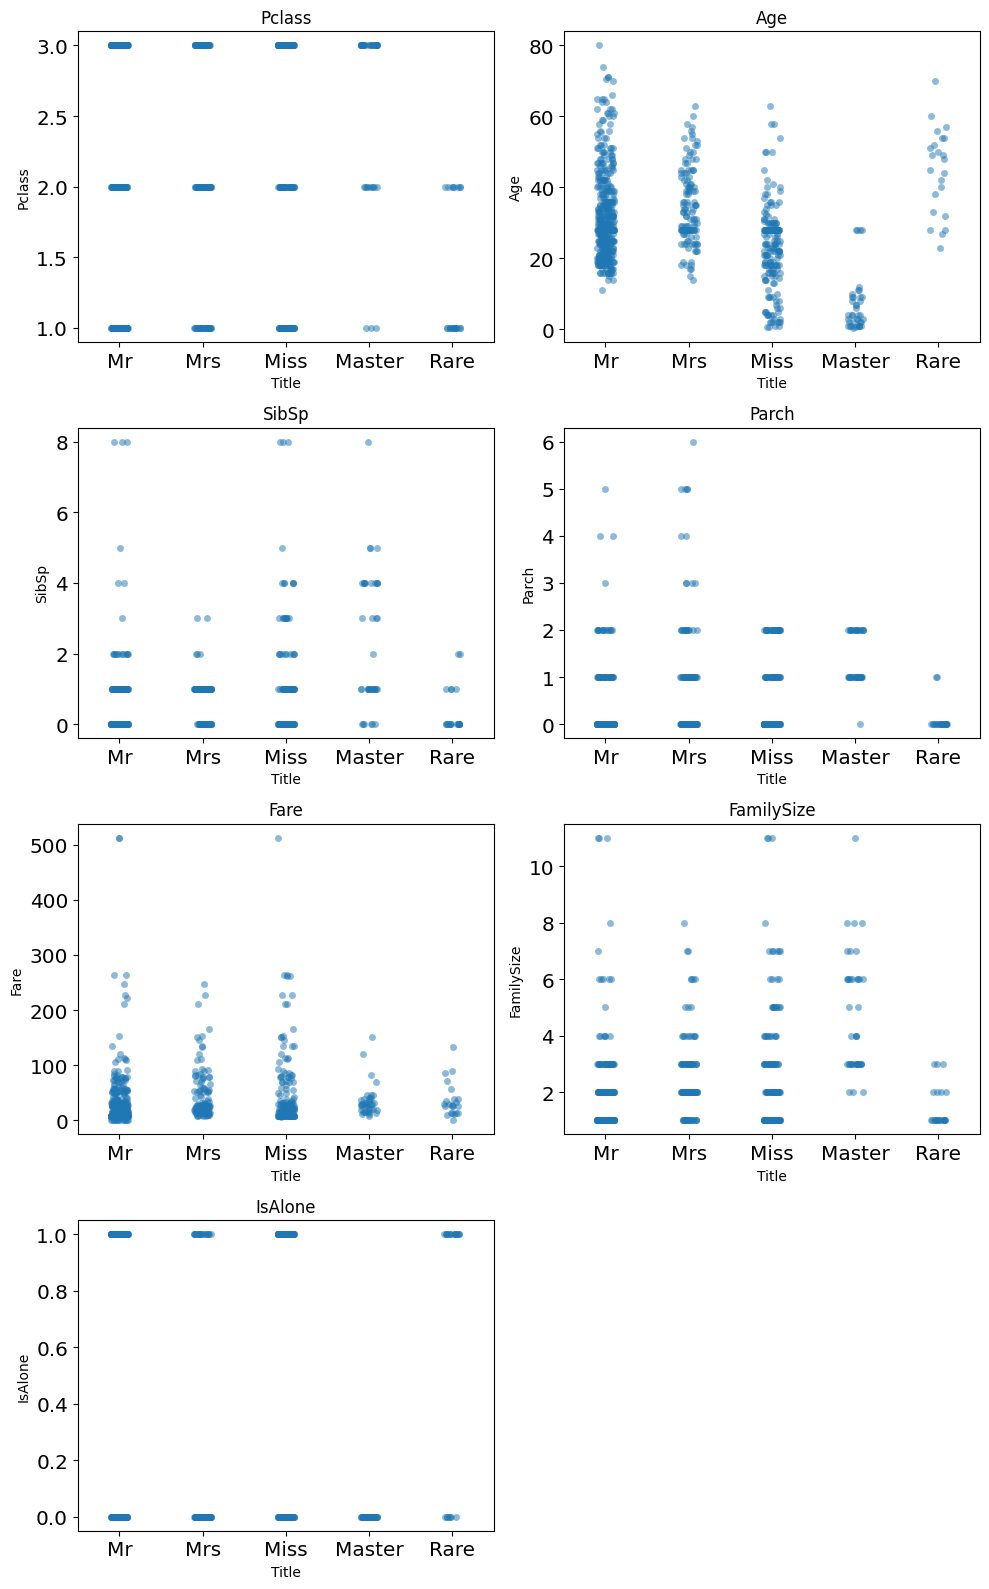

In [28]:
n_cols = 2
n_rows = math.ceil(len(num) / n_cols)

plt.figure(figsize=(10, 4 * n_rows))

for i, col in enumerate(num):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.stripplot(
        data=data2,
        x="Title",
        y=col,
        jitter=True,
        alpha=0.5
    )
    plt.title(col)

plt.tight_layout()
plt.show()

In [29]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    889 non-null    int64  
 1   Pclass      889 non-null    int64  
 2   Sex         889 non-null    object 
 3   Age         889 non-null    float64
 4   SibSp       889 non-null    int64  
 5   Parch       889 non-null    int64  
 6   Fare        889 non-null    float64
 7   Embarked    889 non-null    object 
 8   Title       889 non-null    object 
 9   FamilySize  889 non-null    int64  
 10  IsAlone     889 non-null    int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 83.3+ KB


In [30]:
data2.isna().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
Title         0
FamilySize    0
IsAlone       0
dtype: int64

In [31]:
df_clean = data2

df_clean.to_csv("titanic_survived_clean.csv", index=False)
print("Saved: titanic_survived_clean.csv")

Saved: titanic_survived_clean.csv


## Machine Learning Training

In [32]:
data_clean = data2.copy()

X = data_clean[num + cat]
y = data_clean[target].astype(int)

X = pd.get_dummies(X, columns=cat, drop_first=False)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=75)

In [34]:
model = XGBClassifier()
model.fit(X_train, y_train)
preds = model.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.8146067415730337

## Inference 

In [35]:
test_df = pd.read_csv("test.csv")

In [36]:
test_clean = test_df.drop(columns=["Cabin", "Ticket"], errors="ignore").copy()

In [37]:
age_median = data_clean["Age"].median()
emb_mode = data_clean["Embarked"].mode()[0]
fare_median = data_clean["Fare"].median()

test_clean["Age"] = test_clean["Age"].fillna(age_median)
test_clean["Embarked"] = test_clean["Embarked"].fillna(emb_mode)
test_clean["Fare"] = test_clean["Fare"].fillna(fare_median)

In [38]:
test_clean["Title"] = test_clean["Name"].str.extract(r' ([A-Za-z]+)\.', expand=False)

rare_titles = ["Lady", "Countess", "Capt", "Col", "Don", "Dr",
               "Major", "Rev", "Sir", "Jonkheer", "Dona"]

test_clean["Title"] = test_clean["Title"].replace(rare_titles, "Rare")
test_clean["Title"] = test_clean["Title"].replace({"Mlle": "Miss", "Ms": "Miss", "Mme": "Mrs"})
test_clean["FamilySize"] = test_clean["SibSp"] + test_clean["Parch"] + 1
test_clean["IsAlone"] = (test_clean["FamilySize"] == 1).astype(int)

In [39]:
test_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          418 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Fare         418 non-null    float64
 8   Embarked     418 non-null    object 
 9   Title        418 non-null    object 
 10  FamilySize   418 non-null    int64  
 11  IsAlone      418 non-null    int64  
dtypes: float64(2), int64(6), object(4)
memory usage: 39.3+ KB


In [40]:
X_2 = test_clean[num + cat].copy()
X_2 = pd.get_dummies(X_2, columns=cat, drop_first=False)

In [41]:
X_2 = X_2.reindex(columns=X.columns, fill_value=0)

In [42]:
test_preds = model.predict(X_2).astype(int)

In [43]:
submission = pd.DataFrame({
    id_col: test_df[id_col],
    target: test_preds
})

submission.to_csv("titanic_infer.csv", index=False)
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
